In [20]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import load_model
from keras.models import load_model
import matplotlib.pyplot as plt

import pickle
import numpy as np


from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [21]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [22]:
# split a univariate dataset into train/test sets
#根据需求更改
#length分割长度
def split_dataset(train, test, length):
	# split into standard weeks
	#train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/length))
	test = array(split(test, len(test)/length))
	return train, test

In [23]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [24]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [25]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [26]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	#verbose, epochs, batch_size = 0, 1, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, input_shape=(n_timesteps, n_features)))
	#model.add(RepeatVector(n_outputs))
	#model.add(LSTM(200, activation='relu', return_sequences=True))
	#model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(Dense(test.shape[1]))

	model.compile(loss='mse', optimizer='adam')
	# fit network
	#model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [27]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [28]:
# evaluate a single model
#def evaluate_model(train, test, n_input):
#更改函数返回值
def evaluate_model(train, test, n_input,model):
	# fit model
	#model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
        
	#score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, test[:, :, 0]

In [29]:
#只对train处理
dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train, test = data[0:95016], data[95016:103776]
train = scaler.fit_transform(train)
test = scaler.transform(test)
length = 6
train, test = split_dataset(train, test, length)

n_input = 6

In [30]:
all_mae_histories = []
verbose, epochs, batch_size = 1, 1, 16
train_x, train_y = to_supervised(train, n_input)
model = build_model(train, n_input)


In [47]:
test.shape[1]

6

In [31]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
#train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
mae_history = history.history['loss']
all_mae_histories.append(mae_history)


file = open('history81.pkl', 'wb')
pickle.dump(all_mae_histories, file)
file.close()

model.save('model81.h5')

Epoch 1/1
95004/95004 [==============================] - 88s 923us/step - loss: 0.0063


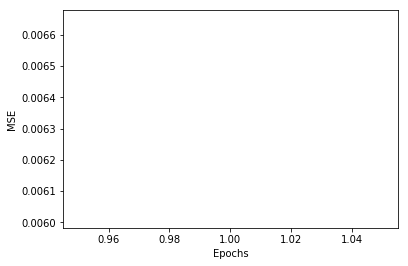

In [32]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
#读取模型
model = load_model('model20193.h5')
file = open('history20193.pkl', 'rb')
load = pickle.load(file)

In [ ]:
#读取模型数据，画图
epochs = 3
average_mae_history = [
    np.mean([x[i] for x in load]) for i in range(epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [33]:
pre, act = evaluate_model(train, test, n_input,model)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


In [34]:
reshape_test = test.reshape([len(test)*length,2])
#去标准化，还原原值
inv_test = scaler.inverse_transform(reshape_test)

In [35]:
concat_test_pre = np.concatenate((pre.reshape([len(pre)*length,1]), test.reshape([len(test)*length,2])[:,-1 :]), axis=1)


In [36]:
concat_test_pre

array([[0.30597675, 0.25233645],
       [0.29659349, 0.24299065],
       [0.30385938, 0.22429907],
       ...,
       [0.47904879, 0.26168224],
       [0.44221175, 0.23364486],
       [0.38509694, 0.24299065]])

In [37]:
inv_test

array([[13821.,    20.],
       [13280.,    19.],
       [12885.,    17.],
       ...,
       [15525.,    21.],
       [14759.,    18.],
       [14071.,    19.]])

In [38]:
inv_testsplit = array(split(inv_test, len(inv_test)/length))
inv_testsplit

array([[[1.3821e+04, 2.0000e+01],
        [1.3280e+04, 1.9000e+01],
        [1.2885e+04, 1.7000e+01],
        [1.2729e+04, 1.7000e+01],
        [1.2779e+04, 1.7000e+01],
        [1.3137e+04, 1.7000e+01]],

       [[1.3633e+04, 1.7000e+01],
        [1.3968e+04, 1.7000e+01],
        [1.4498e+04, 1.7000e+01],
        [1.5023e+04, 1.9000e+01],
        [1.5407e+04, 2.2000e+01],
        [1.5614e+04, 2.3000e+01]],

       [[1.5671e+04, 2.4000e+01],
        [1.5548e+04, 2.5000e+01],
        [1.5505e+04, 2.6000e+01],
        [1.5735e+04, 2.6000e+01],
        [1.7002e+04, 2.5000e+01],
        [1.8231e+04, 2.4000e+01]],

       ...,

       [[1.4850e+04, 1.7000e+01],
        [1.5829e+04, 1.7000e+01],
        [1.6430e+04, 1.8000e+01],
        [1.6614e+04, 2.1000e+01],
        [1.6602e+04, 2.4000e+01],
        [1.6445e+04, 2.6000e+01]],

       [[1.6240e+04, 2.8000e+01],
        [1.6052e+04, 2.8000e+01],
        [1.5919e+04, 2.8000e+01],
        [1.6014e+04, 2.8000e+01],
        [1.7075e+04, 2.7000

In [39]:
inv_testsplit_0 = inv_testsplit[:, :, 0]
inv_testsplit_0

array([[13821., 13280., 12885., 12729., 12779., 13137.],
       [13633., 13968., 14498., 15023., 15407., 15614.],
       [15671., 15548., 15505., 15735., 17002., 18231.],
       ...,
       [14850., 15829., 16430., 16614., 16602., 16445.],
       [16240., 16052., 15919., 16014., 17075., 18123.],
       [17708., 16955., 16243., 15525., 14759., 14071.]])

In [40]:
inv_pre = scaler.inverse_transform(concat_test_pre)

In [41]:
inv_pre

array([[1.38609070e+04, 2.00000000e+01],
       [1.36748557e+04, 1.90000000e+01],
       [1.38189238e+04, 1.70000000e+01],
       ...,
       [1.72925794e+04, 2.10000000e+01],
       [1.65621745e+04, 1.80000000e+01],
       [1.54297021e+04, 1.90000000e+01]])

In [42]:
inv_presplit = array(split(inv_pre, len(inv_pre)/length))
inv_presplit

array([[[1.38609070e+04, 2.00000000e+01],
        [1.36748557e+04, 1.90000000e+01],
        [1.38189238e+04, 1.70000000e+01],
        [1.42060270e+04, 1.70000000e+01],
        [1.47463629e+04, 1.70000000e+01],
        [1.51211151e+04, 1.70000000e+01]],

       [[1.38778924e+04, 1.70000000e+01],
        [1.48219126e+04, 1.70000000e+01],
        [1.55494421e+04, 1.70000000e+01],
        [1.62501998e+04, 1.90000000e+01],
        [1.66528507e+04, 2.20000000e+01],
        [1.67864501e+04, 2.30000000e+01]],

       [[1.57982775e+04, 2.40000000e+01],
        [1.61806503e+04, 2.50000000e+01],
        [1.64579161e+04, 2.60000000e+01],
        [1.68683280e+04, 2.60000000e+01],
        [1.71495796e+04, 2.50000000e+01],
        [1.71731969e+04, 2.40000000e+01]],

       ...,

       [[1.45374932e+04, 1.70000000e+01],
        [1.55872267e+04, 1.70000000e+01],
        [1.62769727e+04, 1.80000000e+01],
        [1.68111488e+04, 2.10000000e+01],
        [1.69992926e+04, 2.40000000e+01],
        [1.6863

In [43]:
inv_presplit_0 = inv_presplit[:, :, 0]
inv_presplit_0

array([[13860.90696859, 13674.85566545, 13818.9238435 , 14206.02696538,
        14746.36285055, 15121.11514413],
       [13877.89238596, 14821.91262078, 15549.44205832, 16250.19984496,
        16652.85067475, 16786.45010614],
       [15798.27747726, 16180.65028095, 16457.9160645 , 16868.32804346,
        17149.57958543, 17173.19690299],
       ...,
       [14537.49315429, 15587.22669363, 16276.97267771, 16811.14880812,
        16999.29256058, 16863.18703556],
       [16325.41338146, 16486.57688808, 16679.02372324, 16993.63686097,
        17222.40993977, 17124.16941524],
       [18494.96185255, 18282.12057996, 17885.73114324, 17292.57937932,
        16562.17452288, 15429.70207512]])

In [44]:
score, scores = evaluate_forecasts(inv_testsplit_0, inv_presplit_0)
summarize_scores('lstm', score, scores)

lstm: [1090.042] 433.4, 720.0, 830.0, 1042.9, 1354.7, 1676.7


In [16]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('../data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, 1)


# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history




(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Train on 8760 samples, validate on 35037 samples
Epoch 1/10
 - 4s - loss: 95.1373 - val_loss: 91.2584
Epoch 2/10
 - 3s - loss: 93.0137 - val_loss: 89.1868
Epoch 3/10
 - 3s - loss: 91.2779 - val_loss: 87.4318
Epoch 4/10
 - 3s - loss: 89.6874 - val_loss: 85.7846
Epoch 5/10
 - 3s - loss: 88.1584 - val_loss: 84.2542
Epoch 6/10
 - 3s - loss: 86.7480 - val_loss: 82.8532
Epoch 7/10
 - 3s - loss: 85.4250 - val_loss: 81.5926
Epoch 8/10
 - 3s - loss: 84.2046 - val_loss: 80.4408
Epoch 9/10
 - 3s - loss: 83.0747 - val_loss: 79.3848
Epoch 10/10
 - 3s - loss: 82.0477 - val_loss: 78.4443


In [17]:
train_X

array([[[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
        [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
        [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ]],

       [[148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
        [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
        [181.  ,  -7.  ,  -5.  , ...,   5.36,   1.  ,   0.  ]],

       [[159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
        [181.  ,  -7.  ,  -5.  , ...,   5.36,   1.  ,   0.  ],
        [138.  ,  -7.  ,  -5.  , ...,   6.25,   2.  ,   0.  ]],

       ...,

       [[  0.  , -18.  ,  -5.  , ...,  62.14,   0.  ,   0.  ],
        [  0.  , -18.  ,  -9.  , ...,  66.16,   0.  ,   0.  ],
        [  0.  , -17.  ,  -7.  , ...,  71.08,   0.  ,   0.  ]],

       [[  0.  , -18.  ,  -9.  , ...,  66.16,   0.  ,   0.  ],
        [  0.  , -17.  ,  -7.  , ...,  71.08,   0.  ,   0.  ],
        [ 36.  , -17.  ,  -7.  , ...,  75.1 ,   0.  ,   0.  ]],

       [[  0.  , -17.  ,  -7.  ,

In [12]:
train_y.shape

(8760,)

In [7]:
test_y.shape

(35037, 1)

In [8]:
test_X.shape

(35037, 24)

In [9]:
train_X.shape[1]

3

In [10]:
train_X.shape[2]

8

In [19]:
train_y

array([181., 138., 109., ...,  36.,  31.,  20.], dtype=float32)

In [13]:
test_y

array([[0.01911469],
       [0.01810865],
       [0.01710262],
       ...,
       [0.01006036],
       [0.00804829],
       [0.01207243]], dtype=float32)

In [14]:
test_X

array([[0.0362173 , 0.33823532, 0.1967213 , ..., 0.0145091 , 0.        ,
        0.        ],
       [0.03118712, 0.33823532, 0.1967213 , ..., 0.006101  , 0.        ,
        0.        ],
       [0.02012072, 0.33823532, 0.1967213 , ..., 0.006101  , 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.27868852, ..., 0.40558836, 0.        ,
        0.        ],
       [0.00804829, 0.25000003, 0.27868852, ..., 0.41399646, 0.        ,
        0.        ],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.4208665 , 0.        ,
        0.        ]], dtype=float32)